In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [7]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/batch_corrected/Hao_PBMC_Harmony_unscaled.h5ad')
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
labels = adata.obs['celltype.l1']
types = np.unique(labels).tolist()
types

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']

## Count ADlasso features

In [8]:
# os.chdir('/home/jovyan/work/GitHub/EvanPys/Progress/PBMC_Hao/Level2_pvl0_ttsplit/lambda_decision_ignore_section/L2_feature_selection')
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level2_pvl0_ttsplit\lambda_decision_ignore_section\L2_feature_selection")
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,11,6
CD4_T,346,197
CD8_T,22,7
DC,32,15
Mono,19,10
NK,33,17
other,4,2
other_T,59,25


## Evaluate by DEGn

In [9]:
def LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)
    # print("Precision: {:.2f}%".format(precision * 100))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # print("F1: {:.2f}%".format(f1 * 100))
    roc_auc = roc_auc_score(y_test, y_score)
    # print('ROC-AUC:', roc_auc)
    average_precision = average_precision_score(y_test, y_score)  # PR-AUC
    mcc = matthews_corrcoef(y_test, y_pred)

    # model metrics
    metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]

    return clf, metrics

In [10]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/DEG_L1/DEG_table')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG1000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier(adata, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics

Constructing classifier for: B
n: 11
(161764, 11)
Constructing classifier for: CD4_T
n: 346
(161764, 346)
Constructing classifier for: CD8_T
n: 22
(161764, 22)
Constructing classifier for: DC
n: 32
(161764, 32)
Constructing classifier for: Mono
n: 19
(161764, 19)
Constructing classifier for: NK
n: 33
(161764, 33)
Constructing classifier for: other
n: 4
(161764, 4)
Constructing classifier for: other_T
n: 59
(161764, 59)


In [11]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998424,0.995247,0.986232,0.990719,0.999571,0.998979,0.989870
CD4_T,0.955986,0.911865,0.914756,0.913308,0.988932,0.967846,0.883816
CD8_T,0.969647,0.929048,0.873969,0.900668,0.986854,0.955660,0.883348
DC,0.998053,0.967190,0.944290,0.955603,0.999332,0.988695,0.954679
Mono,0.992736,0.980126,0.996225,0.988110,0.997803,0.990638,0.982949
NK,0.989398,0.955645,0.952317,0.953978,0.998292,0.989659,0.947989
other,0.991655,0.935417,0.652616,0.768836,0.909594,0.774637,0.777603
other_T,0.983371,0.857766,0.723859,0.785144,0.982037,0.860176,0.779587


In [12]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/DEG_L1')

all_metrics_DEG.to_csv('L1_Harmony_DEGn_metrics.csv')

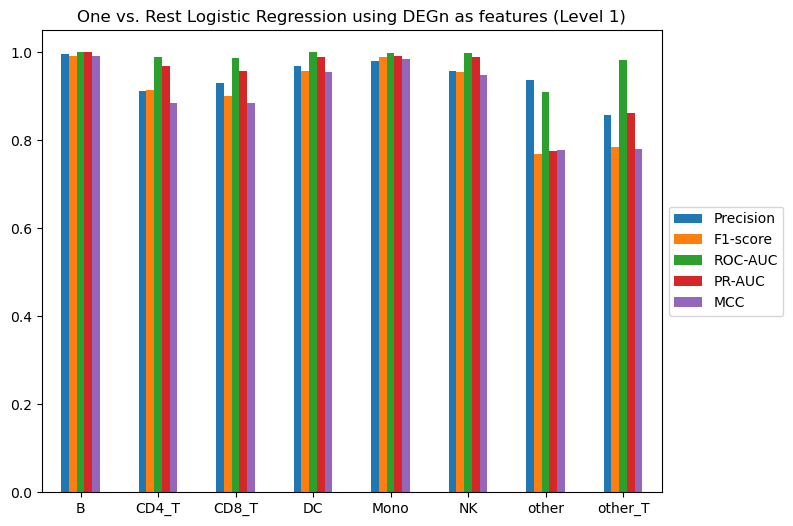

In [13]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
# Plot metrics for each celltype
ax = all_metrics_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression using DEGn as features (Level 1)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Combine plots: ADlasso features vs. DEG

In [14]:
all_metrics_PreLect = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/LR_classifiers/LR_metrics_l1.csv', index_col=0)
all_metrics_PreLect

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999060,0.996434,0.992536,0.994477,0.999932,0.999467,0.993968
CD4_T,0.972732,0.946886,0.946806,0.946451,0.995329,0.986740,0.928516
CD8_T,0.971533,0.935854,0.879462,0.906743,0.988621,0.958425,0.890590
DC,0.998399,0.969838,0.957648,0.963695,0.999792,0.992209,0.962901
Mono,0.992260,0.979353,0.995450,0.987332,0.998171,0.993200,0.981832
NK,0.992563,0.969349,0.966246,0.967753,0.998681,0.994031,0.963578
other,0.991729,0.926873,0.659126,0.756311,0.930343,0.782826,0.770412
other_T,0.985714,0.881007,0.762698,0.817384,0.986354,0.885081,0.812385


In [15]:
PreLect_minus_DEG = all_metrics_PreLect - all_metrics_DEG
PreLect_minus_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.000637,0.001187,0.006304,0.003758,0.000362,0.000487,0.004099
CD4_T,0.016746,0.035021,0.032050,0.033143,0.006396,0.018893,0.044701
CD8_T,0.001885,0.006805,0.005492,0.006076,0.001766,0.002765,0.007242
DC,0.000346,0.002648,0.013358,0.008092,0.000460,0.003514,0.008223
Mono,-0.000476,-0.000774,-0.000775,-0.000778,0.000368,0.002562,-0.001117
NK,0.003165,0.013704,0.013928,0.013775,0.000389,0.004372,0.015589
other,0.000074,-0.008544,0.006509,-0.012524,0.020749,0.008189,-0.007191
other_T,0.002343,0.023241,0.038840,0.032240,0.004317,0.024906,0.032798


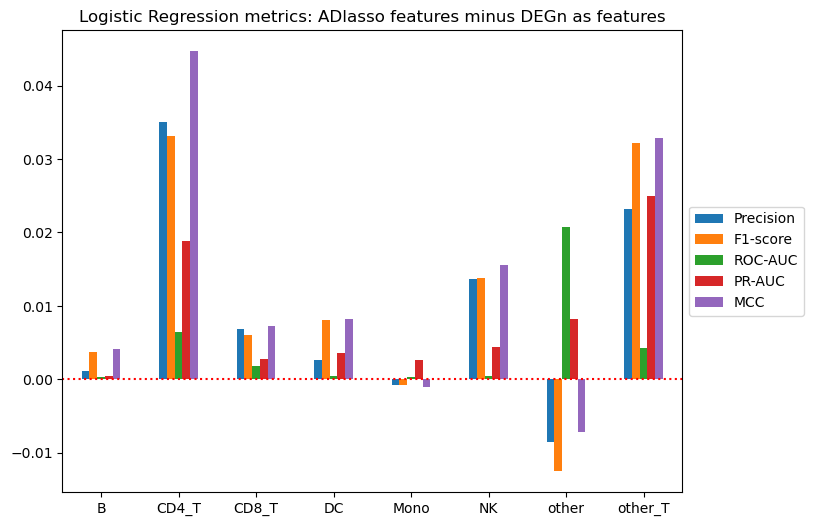

In [16]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = PreLect_minus_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='Logistic Regression metrics: ADlasso features minus DEGn as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Add vertical red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')
